# Part 7.2 - Sentiment Analysis on Topic Modeling
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

from sklearn.preprocessing import MinMaxScaler
import textblob as tb

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

2019-01-31 10:13:25
[('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1548882807599'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '35090'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

**Did people live with happyness or not? In this part we will apply a sentiment analysis process to topics to find the answer.**

**We consider each topic has a score of sentiment more or less, we can use a sentiment tool (TextBlob) to get the score. Then we multiply the score of each topic to the corresponding topic weight in average weight-year matrix, we get the sentiment-year matrix. This matrix is the answer of the question.**

## 1 Load Data

**Load metadata:**

In [2]:
df_meta = load_dataset('meta', spark).select(F.col('id').alias('id_'), F.col('region'), F.col('date'))
df_meta.cache()

DataFrame[id_: int, region: string, date: date]

In [3]:
df_meta.limit(5).toPandas().head()

,id_,region,date
0,1854213,Auckland,1862-06-14
1,1854215,Auckland,1862-06-14
2,1854221,Auckland,1862-06-14
3,1854224,Auckland,1862-07-03
4,1854232,Auckland,1863-08-01


**Topic List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic', 'weight', 'keywords'],
                           encoding='utf8')
             .sort_values(by='topic')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

**Load doc-topic matrix:**

In [6]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id')
df_doctopic.cache();

In [7]:
print('Shape of dataframe:({}, {})'.format(df_doctopic.count(), len(df_doctopic.columns)))
df_doctopic.limit(5).toPandas().head()

Shape of dataframe:(3025602, 201)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1854213,0.000048,0.000271,0.000035,0.000267,0.000526,0.000271,0.000108,0.000097,0.000119,0.000099,0.000183,0.000308,0.000089,0.000245,0.000174,0.000220,0.000105,0.000195,0.000162,0.000106,0.000062,0.000201,0.000177,0.000266,0.000162,0.000402,0.000059,0.000231,0.000406,0.000184,0.000119,0.000165,0.000226,0.000305,0.000190,0.000285,0.000245,0.000212,0.001180,0.000047,0.000163,0.000130,0.836856,0.000117,0.000070,0.000226,0.000114,0.000292,0.000209,0.000221,0.000259,0.000103,0.000459,0.000179,0.000226,0.000375,0.000306,0.000181,0.000297,...,0.000173,0.000134,0.000209,0.000201,0.000163,0.000160,0.060030,0.000203,0.000249,0.000088,0.000208,0.000206,0.000230,0.000187,0.000215,0.000275,0.000181,0.000051,0.000193,0.000235,0.000063,0.000152,0.000180,0.000470,0.000122,0.000221,0.000175,0.000179,0.059977,0.000246,0.000145,0.000224,0.000209,0.000364,0.000098,0.000281,0.000189,0.000103,0.000156,0.000195,0.000116,0.000242,0.000158,0.000255,0.000205,0.000294,0.000117,0.000226,0.000207,0.000260,0.000085,0.000171,0.000413,0.000192,0.000238,0.000102,0.000266,0.000159,0.000215,0.000231
1,1854215,0.000028,0.000155,0.000020,0.000153,0.000301,0.000155,0.000062,0.000056,0.000068,0.000057,0.000105,0.000176,0.000051,0.000140,0.000100,0.000126,0.000060,0.000112,0.000093,0.000060,0.000036,0.000115,0.000101,0.000152,0.000093,0.000230,0.000034,0.000132,0.000233,0.000105,0.000068,0.000094,0.000129,0.000174,0.000109,0.000163,0.000140,0.000121,0.000676,0.000027,0.000093,0.000075,0.000310,0.000067,0.000040,0.239527,0.000065,0.000167,0.000120,0.000127,0.000148,0.000059,0.000263,0.000103,0.000129,0.000215,0.290872,0.000104,0.000170,...,0.000099,0.000077,0.000120,0.000115,0.000093,0.000092,0.000168,0.000116,0.000142,0.000051,0.000119,0.000118,0.000131,0.000107,0.000123,0.000157,0.000103,0.000029,0.000111,0.000135,0.000036,0.000087,0.000103,0.000269,0.000070,0.000127,0.000100,0.000103,0.000137,0.000141,0.000083,0.000129,0.000120,0.034408,0.000056,0.000161,0.000108,0.000059,0.000089,0.000112,0.000066,0.000138,0.000091,0.000146,0.000117,0.000168,0.000067,0.000129,0.000119,0.000149,0.000049,0.359194,0.000237,0.000110,0.000136,0.000059,0.000152,0.000091,0.000123,0.000132
2,1854221,0.000039,0.000219,0.000028,0.000215,0.000424,0.000219,0.000087,0.000078,0.000096,0.000080,0.000148,0.000249,0.000072,0.000198,0.000140,0.000178,0.000085,0.000158,0.000130,0.000085,0.000050,0.000162,0.000143,0.000214,0.000131,0.000324,0.000047,0.000186,0.000328,0.000148,0.000096,0.000133,0.000182,0.000246,0.000154,0.000230,0.000198,0.000171,0.000952,0.000038,0.000132,0.000105,0.000437,0.000094,0.000056,0.000182,0.000092,0.000236,0.000169,0.000179,0.000209,0.000083,0.000370,0.000145,0.000182,0.000303,0.000247,0.000146,0.048456,...,0.000140,0.000108,0.000169,0.000162,0.000132,0.000130,0.000237,0.000164,0.000201,0.000071,0.000168,0.000166,0.000185,0.000151,0.000173,0.000222,0.000146,0.000041,0.000156,0.000190,0.000051,0.000123,0.000145,0.000379,0.000099,0.000178,0.000141,0.000145,0.000194,0.000199,0.000117,0.000181,0.000169,0.000294,0.000079,0.000227,0.000152,0.000083,0.000126,0.000158,0.000093,0.000195,0.000128,0.000206,0.000165,0.000237,0.000094,0.000182,0.000167,0.000210,0.000069,0.000138,0.000334,0.868039,0.000192,0.000083,0.000214,0.000128,0.000174,0.000186
3,1854224,0.000036,0.000204,0.000026,0.000201,0.000396,0.000204,0.000081,0.000073,0.000089,0.000075,0.000138,0.000232,0.000067,0.000185,0.000131,0.000166,0.000079,0.000147,0.000122,0.000079,0.000047,0.000151,0.000133,0.000200,0.000122,0.000302,0.000044,0.000174,0.000306,0.000138,0.000089,0.000124,0.000170,0.000229,0.000143,0.000

## 2 Generate Dataset

**We need to generate average-weight-year matrix for analysis.**

In [8]:
# doc-weight-year matrix
df = (df_doctopic
      .join(df_meta, df_doctopic.id == df_meta.id_)
      .withColumn('year', F.date_format('date', 'yyyy'))
      .drop('id')
      .drop('id_')
      .drop('region')
      .drop('date')
      .orderBy('year')
      )

df.limit(5).toPandas().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,year
0,0.035477,0.000025,0.000003,0.000024,0.098280,0.000025,0.000010,0.000009,0.000011,0.000009,0.000017,0.000028,0.000008,0.065510,0.117348,0.000020,0.000010,0.000018,0.000015,0.000010,0.000006,0.000018,0.000016,0.000024,0.000015,0.000037,0.000005,0.000021,0.000037,0.005474,0.000011,0.010930,0.000021,0.000028,0.000017,0.000026,0.000022,0.000019,0.000108,0.000004,0.000015,0.000012,0.000049,0.000011,0.000006,0.000021,0.000010,0.000027,0.000019,0.000020,0.000024,0.000009,0.144661,0.000016,0.000021,0.000034,0.000028,0.000017,0.000027,0.000017,...,0.000012,0.000019,0.000018,0.000015,0.000015,0.204676,0.000019,0.000023,0.000008,0.000019,0.000019,0.000021,0.000017,0.000020,0.000025,0.000016,0.000005,0.000018,0.000021,0.000006,0.000014,0.000016,0.000043,0.000011,0.000020,0.000016,0.000016,0.000022,0.000022,0.000013,0.000021,0.000019,0.000033,0.002738,0.002754,0.000017,0.000009,0.000014,0.000018,0.000011,0.000022,0.000014,0.000023,0.000019,0.000027,0.000011,0.000021,0.000019,0.000024,0.000008,0.000016,0.000038,0.000018,0.000022,0.000009,0.038226,0.000015,0.000020,0.000021,1839
1,0.000009,0.000053,0.000007,0.000052,0.000103,0.000053,0.000021,0.000019,0.000023,0.000019,0.000036,0.000060,0.000018,0.000048,0.000034,0.000043,0.000021,0.000038,0.000032,0.000021,0.000012,0.000039,0.000035,0.000052,0.000032,0.000079,0.000012,0.000045,0.000080,0.000036,0.000023,0.000032,0.000044,0.000060,0.000037,0.000056,0.000048,0.000042,0.000232,0.000009,0.000032,0.000026,0.000106,0.000023,0.000014,0.000044,0.000022,0.000057,0.035236,0.000043,0.000051,0.000020,0.000090,0.000035,0.000044,0.000074,0.000060,0.000036,0.123240,0.000037,...,0.000026,0.000041,0.000039,0.000032,0.258126,0.064581,0.000040,0.000049,0.000017,0.000041,0.000040,0.000045,0.000037,0.000042,0.029383,0.000035,0.000010,0.000038,0.000046,0.000012,0.000030,0.000035,0.000092,0.000024,0.000043,0.000034,0.000035,0.000047,0.000048,0.000029,0.000044,0.000041,0.000071,0.000019,0.000055,0.000037,0.000020,0.000031,0.000038,0.000023,0.041108,0.000031,0.000050,0.000040,0.000058,0.000023,0.000044,0.000041,0.000051,0.000017,0.000034,0.000081,0.000038,0.000047,0.000020,0.000052,0.000031,0.000042,0.000045,1839
2,0.000005,0.000028,0.000004,0.000028,0.000055,0.000028,0.000011,0.000010,0.000012,0.000010,0.000019,0.006273,0.000009,0.000026,0.000018,0.000023,0.000011,0.000020,0.000017,0.000011,0.000007,0.000021,0.000018,0.000028,0.000017,0.000042,0.000006,0.000024,0.000042,0.000019,0.000012,0.000017,0.000024,0.000032,0.000020,0.000030,0.000026,0.000022,0.000123,0.000005,0.000017,0.000014,0.000057,0.000012,0.000007,0.000024,0.000012,0.000031,0.024984,0.000023,0.000027,0.000011,0.218470,0.000019,0.000024,0.000039,0.000032,0.000019,0.000031,0.000020,...,0.000014,0.000022,0.000021,0.000017,0.093626,0.352626,0.000021,0.000026,0.000009,0.000022,0.000022,0.000024,0.000019,0.000022,0.000029,0.000019,0.000005,0.000020,0.000025,0.000007,0.000016,0.000019,0.000049,0.000013,0.000023,0.000018,0.000019,0.000025,0.000026,0.000015,0.000023,0.000022,0.000038,0.000010,0.000029,0.000020,0.000011,0.000016,0.000020,0.000012,0.000025,0.000017,0.000027,0.000021,0.000031,0.000012,0.000024,0.000022,0.000027,0.000009,0.000018,0.000043,0.000020,0.000025,0.000011,0.000028,0.000017,0.000023,0.000024,1839
3,0.000005,0.000027,0.000004,0.000027,0.000053,0.000027,0.000011,0.000010,0.000012,0.000010,0.000019,0.000031,0.000009,0.000025,0.000018,0.081722,0.000011,0.000020,0.000016,0.000011,0.000006,0.000020,0.000018,0.000027,0.000016,0.000041,0.000006,0.000023,0.000041,0.000019,0.000012,0.000017,0.000023,0.000031,0.000019,0.000029,0.000025,0.0

In [9]:
# avg-weight-year matrix
df = (df
      .groupBy('year')
      .avg()
      .orderBy('year'))

df = df.toPandas()

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'year')
df.columns = columns

print('Shape of dataframe:', df.shape)
df.head()

Shape of dataframe: (104, 201)


,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839,0.005073,0.000030,0.000004,0.000029,0.021866,0.000030,0.000012,0.000011,0.000013,0.000011,0.009596,0.000925,0.000010,0.009382,0.016781,0.036187,0.000012,0.000022,0.000018,0.000012,0.000007,0.000022,0.000019,0.000029,0.000018,0.000044,0.000006,0.001120,0.000045,0.000800,0.000013,0.001577,0.000025,0.012733,0.000021,0.000031,0.000027,0.000023,0.000130,0.000005,0.000018,0.000014,0.000516,0.000013,0.000008,0.000025,0.000013,0.000032,0.015913,0.000024,0.000029,0.000011,0.057568,0.000020,0.000025,0.000041,0.000034,0.006130,0.021187,...,0.003527,0.000015,0.000023,0.005311,0.000018,0.093818,0.214674,0.000022,0.000027,0.000010,0.000023,0.003913,0.000025,0.000021,0.000024,0.004220,0.000020,0.000006,0.000021,0.000026,0.000007,0.002844,0.000020,0.000829,0.000013,0.000024,0.000019,0.000020,0.000026,0.000027,0.000016,0.000025,0.000023,0.005483,0.000401,0.000421,0.000021,0.019082,0.000017,0.000022,0.000013,0.057941,0.000017,0.000028,0.000023,0.000032,0.003039,0.004129,0.005130,0.000029,0.000009,0.000019,0.000046,0.000021,0.000026,0.000011,0.005487,0.000018,0.000024,0.000025
1,1840,0.000449,0.000176,0.000014,0.007261,0.009739,0.000715,0.002324,0.000252,0.001538,0.003425,0.001443,0.004534,0.000460,0.008074,0.001544,0.011813,0.000043,0.001300,0.000193,0.004661,0.000291,0.000463,0.000498,0.003416,0.000706,0.000628,0.000024,0.001054,0.002496,0.002982,0.000152,0.000344,0.000129,0.005345,0.028947,0.001281,0.002734,0.000948,0.102480,0.000234,0.004365,0.000309,0.014919,0.000088,0.000029,0.002068,0.065434,0.000662,0.011859,0.002905,0.003011,0.000042,0.043962,0.001139,0.000519,0.002221,0.021192,0.015699,0.000492,...,0.001787,0.000084,0.000214,0.014990,0.000741,0.042252,0.060052,0.000373,0.001413,0.002326,0.004787,0.001905,0.000677,0.000336,0.000189,0.001106,0.001318,0.000049,0.000145,0.003761,0.000026,0.000248,0.011232,0.003117,0.000577,0.000804,0.000237,0.000322,0.003709,0.000567,0.000289,0.000444,0.000207,0.001772,0.000329,0.005528,0.000643,0.009305,0.000342,0.000080,0.000575,0.021943,0.013308,0.002491,0.000265,0.001548,0.097498,0.020766,0.002562,0.002677,0.000035,0.011768,0.009479,0.000414,0.005261,0.000210,0.000701,0.000172,0.000144,0.001667
2,1841,0.000049,0.000946,0.000016,0.001829,0.005646,0.002464,0.000049,0.000489,0.003126,0.001813,0.001991,0.020814,0.000041,0.002062,0.001312,0.013236,0.000048,0.001096,0.000090,0.035339,0.000272,0.001040,0.000257,0.003316,0.000369,0.000660,0.000027,0.002739,0.008087,0.000324,0.000445,0.000075,0.000211,0.003949,0.042482,0.001000,0.001852,0.001031,0.004192,0.000086,0.002755,0.007079,0.006683,0.000053,0.000043,0.000769,0.081503,0.001173,0.018822,0.004851,0.000589,0.000082,0.063086,0.000146,0.000371,0.000848,0.005556,0.011903,0.000741,...,0.000333,0.000322,0.000130,0.008576,0.001129,0.032117,0.066355,0.000181,0.000182,0.000734,0.000598,0.005972,0.000593,0.000100,0.000545,0.000297,0.003860,0.000023,0.002551,0.002889,0.000169,0.002816,0.012088,0.003812,0.000098,0.001205,0.000243,0.000401,0.003706,0.000706,0.000102,0.000160,0.000306,0.005142,0.000482,0.004232,0.002612,0.011223,0.000518,0.000236,0.001510,0.012617,0.008820,0.000999,0.000093,0.000311,0.070728,0.049934,0.004870,0.004500,0.000494,0.020519,0.013599,0.001853,0.002235,0.000058,0.002113,0.000317,0.001370,0.000260
3,1842,0.000042,0.002522,0.000177,0.007565,0.004207,0.003089,0.000446,0.000082,0.002794,0.009556,0.003025,0.021126,0.000078,0.007963,0.000543,0.007461,0.000053,0.003217,0.000309,0.006146,0.000112,0.000732,0.000226,0.001999,0.000280,0.001958,0.000017,0.000727,0.010231,0.000071,0.000241,0.000899,0.000254,0.013883,0.016274,0.000919,0.0012

## 3 Topics Sentiment Analysis

**Use some sentences to check the sentiment analysis result:**

In [10]:
text = []
text.append('I am very happy today!')
text.append('The sun rises every day.')
text.append('He was badly wounded on the battlefield.')

for i in range(len(text)):
    t = tb.TextBlob(text[i])
    print('\nText:', text[i])
    print('Polarity = ', t.sentiment.polarity)
    print('Subjectivity = ', t.sentiment.subjectivity)


Text: I am very happy today!
Polarity =  1.0
Subjectivity =  1.0

Text: The sun rises every day.
Polarity =  0.0
Subjectivity =  0.0

Text: He was badly wounded on the battlefield.
Polarity =  -0.6999999999999998
Subjectivity =  0.6666666666666666


**We see the results of sentiment analysis make sense. Now we apply the process to each topic in topic list.**

In [11]:
df_score = df_topics.drop(columns='weight')

df_score['score'] = df_score['keywords'].apply(lambda x: tb.TextBlob(x).sentiment.polarity)

# scale score to 0 - 1
scaler = MinMaxScaler()
df_score['scaled'] = scaler.fit_transform(df_score[['score']])

df_score = df_score[['topic', 'score', 'scaled', 'keywords']]

df_score.head(10)

,topic,score,scaled,keywords
0,0,0.533333,0.794872,apply wanted good post work experience wellington position wages salary office experienced box required applications...
1,1,-0.200000,0.230769,killed police received people london persons hundred men explosion city women injured thousand number arrested wound...
2,2,0.371429,0.670330,rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...
3,3,0.000000,0.384615,meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...
4,4,0.000000,0.384615,sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...
5,5,-0.020833,0.368590,chinese china japanese japan russia russian turkish troops british turkey received government war constantinople lon...
6,6,0.000000,0.384615,yds prize yards race handicap sports entrance match rifle points events shooting trophy club competition won prizes ...
7,7,0.600000,0.846154,handicap lady furlongs meeting miles mile hack soys king acceptances miss cup gold sir bst royal hurdles day rose club
8,8,-0.083333,0.320513,reward lost ost white found dog finder apply notice black branded person bay return pound returning office gold satu...
9,9,0.400000,0.692308,duty customs duties tariff sugar goods free cent revenue tobacco paid amount beer stamp colony consumption articles ...


**The sorce looks not very coincident with our own feel, which should be caused by multiple reasons (we are not very clear now), take it as future work.**

**Then we multiply each average topic weight with it's sentiment score, get the sentiment-year matrix.**

In [12]:
score_list = df_score.scaled.tolist()

for i in range(len(score_list)):
    df[df.columns[i+1]] = df[df.columns[i+1]] * score_list[i]

df.head()

,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839,0.004032,0.000007,0.000003,0.000011,0.008410,0.000011,0.000005,0.000009,0.000004,0.000008,0.003691,0.000356,0.000006,0.006434,0.009220,0.013918,0.000011,0.000020,0.000008,0.000004,0.000005,0.000006,0.000007,0.000011,0.000008,0.000017,0.000006,0.000775,0.000024,0.000626,0.000005,0.000926,0.000023,0.008081,0.000011,0.000012,0.000019,0.000015,0.000065,0.000003,0.000007,0.000005,0.000304,0.000005,0.000003,0.000014,0.000006,0.000012,0.006120,0.000009,0.000008,0.000006,0.023249,0.000004,0.000010,0.000031,0.000013,0.001886,0.011001,...,0.001441,0.000013,0.000009,0.002043,0.000006,0.037287,0.153339,0.000008,0.000011,0.000003,0.000005,0.003612,0.000010,0.000020,0.000009,0.002143,0.000008,0.000003,0.000015,0.000012,0.000006,0.001065,0.000008,0.000319,0.000005,0.000009,0.000016,0.000008,0.000020,0.000016,0.000008,0.000010,0.000009,0.002109,0.000154,0.000421,0.000010,0.007339,0.000009,0.000008,0.000008,0.019101,0.000008,0.000011,0.000013,0.000012,0.001169,0.003811,0.001973,0.000014,0.000004,0.000005,0.000018,0.000015,0.000010,0.000004,0.001477,0.000005,0.000006,0.000009
1,1840,0.000357,0.000041,0.000010,0.002793,0.003746,0.000264,0.000894,0.000213,0.000493,0.002371,0.000555,0.001744,0.000303,0.005537,0.000848,0.004543,0.000040,0.001200,0.000090,0.001793,0.000191,0.000128,0.000191,0.001314,0.000330,0.000242,0.000022,0.000730,0.001328,0.002332,0.000058,0.000202,0.000119,0.003392,0.015810,0.000493,0.001893,0.000625,0.051240,0.000135,0.001679,0.000104,0.008798,0.000034,0.000011,0.001137,0.030200,0.000255,0.004561,0.001117,0.000849,0.000023,0.017754,0.000241,0.000200,0.001660,0.008151,0.004830,0.000255,...,0.000730,0.000074,0.000082,0.005765,0.000264,0.016792,0.042895,0.000140,0.000571,0.000767,0.001105,0.001758,0.000260,0.000328,0.000070,0.000562,0.000507,0.000024,0.000104,0.001796,0.000024,0.000093,0.004320,0.001199,0.000222,0.000309,0.000201,0.000136,0.002853,0.000335,0.000144,0.000174,0.000080,0.000681,0.000127,0.005528,0.000300,0.003579,0.000188,0.000031,0.000354,0.007234,0.006215,0.000958,0.000150,0.000595,0.037499,0.019169,0.000985,0.001297,0.000013,0.003017,0.003646,0.000287,0.002023,0.000076,0.000189,0.000049,0.000037,0.000577
2,1841,0.000039,0.000218,0.000011,0.000703,0.002172,0.000908,0.000019,0.000414,0.001002,0.001255,0.000766,0.008005,0.000027,0.001414,0.000721,0.005091,0.000044,0.001012,0.000042,0.013592,0.000178,0.000287,0.000099,0.001275,0.000173,0.000254,0.000025,0.001896,0.004303,0.000254,0.000171,0.000044,0.000195,0.002506,0.023202,0.000384,0.001282,0.000680,0.002096,0.000050,0.001060,0.002382,0.003942,0.000020,0.000017,0.000422,0.037617,0.000451,0.007239,0.001866,0.000166,0.000044,0.025477,0.000031,0.000143,0.000633,0.002137,0.003663,0.000385,...,0.000136,0.000286,0.000050,0.003299,0.000402,0.012765,0.047396,0.000068,0.000073,0.000242,0.000138,0.005513,0.000228,0.000097,0.000203,0.000151,0.001485,0.000011,0.001831,0.001380,0.000156,0.001054,0.004649,0.001466,0.000038,0.000463,0.000206,0.000169,0.002851,0.000416,0.000051,0.000063,0.000118,0.001978,0.000185,0.004232,0.001220,0.004317,0.000285,0.000091,0.000929,0.004159,0.004119,0.000384,0.000053,0.000120,0.027203,0.046093,0.001873,0.002181,0.000190,0.005261,0.005230,0.001283,0.000859,0.000021,0.000569,0.000089,0.000351,0.000090
3,1842,0.000033,0.000582,0.000119,0.002910,0.001618,0.001138,0.000172,0.000069,0.000896,0.006616,0.001163,0.008126,0.000051,0.005461,0.000299,0.002870,0.000049,0.002970,0.000145,0.002364,0.000074,0.000202,0.000087,0.000769,0.000131,0.000753,0.000015,0.000503,0.005443,0.000056,0.000093,0.000528,0.000235,0.008810,0.008888,0.000353,0.0008

**The sum of each row is the overall sentiment score of each year.**

In [13]:
# sum each year
df['score'] = df.iloc[:, 1:].sum(axis=1)

# scale score to emplify the difference of each year
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['score']])

df.head()

,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,score,scaled
0,1839,0.004032,0.000007,0.000003,0.000011,0.008410,0.000011,0.000005,0.000009,0.000004,0.000008,0.003691,0.000356,0.000006,0.006434,0.009220,0.013918,0.000011,0.000020,0.000008,0.000004,0.000005,0.000006,0.000007,0.000011,0.000008,0.000017,0.000006,0.000775,0.000024,0.000626,0.000005,0.000926,0.000023,0.008081,0.000011,0.000012,0.000019,0.000015,0.000065,0.000003,0.000007,0.000005,0.000304,0.000005,0.000003,0.000014,0.000006,0.000012,0.006120,0.000009,0.000008,0.000006,0.023249,0.000004,0.000010,0.000031,0.000013,0.001886,0.011001,...,0.000009,0.002043,0.000006,0.037287,0.153339,0.000008,0.000011,0.000003,0.000005,0.003612,0.000010,0.000020,0.000009,0.002143,0.000008,0.000003,0.000015,0.000012,0.000006,0.001065,0.000008,0.000319,0.000005,0.000009,0.000016,0.000008,0.000020,0.000016,0.000008,0.000010,0.000009,0.002109,0.000154,0.000421,0.000010,0.007339,0.000009,0.000008,0.000008,0.019101,0.000008,0.000011,0.000013,0.000012,0.001169,0.003811,0.001973,0.000014,0.000004,0.000005,0.000018,0.000015,0.000010,0.000004,0.001477,0.000005,0.000006,0.000009,0.483085,0.493958
1,1840,0.000357,0.000041,0.000010,0.002793,0.003746,0.000264,0.000894,0.000213,0.000493,0.002371,0.000555,0.001744,0.000303,0.005537,0.000848,0.004543,0.000040,0.001200,0.000090,0.001793,0.000191,0.000128,0.000191,0.001314,0.000330,0.000242,0.000022,0.000730,0.001328,0.002332,0.000058,0.000202,0.000119,0.003392,0.015810,0.000493,0.001893,0.000625,0.051240,0.000135,0.001679,0.000104,0.008798,0.000034,0.000011,0.001137,0.030200,0.000255,0.004561,0.001117,0.000849,0.000023,0.017754,0.000241,0.000200,0.001660,0.008151,0.004830,0.000255,...,0.000082,0.005765,0.000264,0.016792,0.042895,0.000140,0.000571,0.000767,0.001105,0.001758,0.000260,0.000328,0.000070,0.000562,0.000507,0.000024,0.000104,0.001796,0.000024,0.000093,0.004320,0.001199,0.000222,0.000309,0.000201,0.000136,0.002853,0.000335,0.000144,0.000174,0.000080,0.000681,0.000127,0.005528,0.000300,0.003579,0.000188,0.000031,0.000354,0.007234,0.006215,0.000958,0.000150,0.000595,0.037499,0.019169,0.000985,0.001297,0.000013,0.003017,0.003646,0.000287,0.002023,0.000076,0.000189,0.000049,0.000037,0.000577,0.468378,0.079845
2,1841,0.000039,0.000218,0.000011,0.000703,0.002172,0.000908,0.000019,0.000414,0.001002,0.001255,0.000766,0.008005,0.000027,0.001414,0.000721,0.005091,0.000044,0.001012,0.000042,0.013592,0.000178,0.000287,0.000099,0.001275,0.000173,0.000254,0.000025,0.001896,0.004303,0.000254,0.000171,0.000044,0.000195,0.002506,0.023202,0.000384,0.001282,0.000680,0.002096,0.000050,0.001060,0.002382,0.003942,0.000020,0.000017,0.000422,0.037617,0.000451,0.007239,0.001866,0.000166,0.000044,0.025477,0.000031,0.000143,0.000633,0.002137,0.003663,0.000385,...,0.000050,0.003299,0.000402,0.012765,0.047396,0.000068,0.000073,0.000242,0.000138,0.005513,0.000228,0.000097,0.000203,0.000151,0.001485,0.000011,0.001831,0.001380,0.000156,0.001054,0.004649,0.001466,0.000038,0.000463,0.000206,0.000169,0.002851,0.000416,0.000051,0.000063,0.000118,0.001978,0.000185,0.004232,0.001220,0.004317,0.000285,0.000091,0.000929,0.004159,0.004119,0.000384,0.000053,0.000120,0.027203,0.046093,0.001873,0.002181,0.000190,0.005261,0.005230,0.001283,0.000859,0.000021,0.000569,0.000089,0.000351,0.000090,0.476224,0.300755
3,1842,0.000033,0.000582,0.000119,0.002910,0.001618,0.001138,0.000172,0.000069,0.000896,0.006616,0.001163,0.008126,0.000051,0.005461,0.000299,0.002870,0.000049,0.002970,0.000145,0.002364,0.000074,0.000202,0.000087,0.000769,0.000131,0.000753,0.000015,0.000503,0.005443,0.000056,0.000093,0.000528,0.000235,0.008810,0.008888,0.000353,0

## 4 Sentiment Over Time

**Generate dataframe to plot:**

In [14]:
df_plt = df[['year', 'scaled']]

# convert dataframe to time series
df_plt.index = pd.to_datetime(df_plt['year'])
df_plt.drop(columns='year', inplace=True)

df_plt.T

year,1839-01-01 00:00:00,1840-01-01 00:00:00,1841-01-01 00:00:00,1842-01-01 00:00:00,1843-01-01 00:00:00,1844-01-01 00:00:00,1845-01-01 00:00:00,1846-01-01 00:00:00,1847-01-01 00:00:00,1848-01-01 00:00:00,1849-01-01 00:00:00,1850-01-01 00:00:00,1851-01-01 00:00:00,1852-01-01 00:00:00,1853-01-01 00:00:00,1854-01-01 00:00:00,1855-01-01 00:00:00,1856-01-01 00:00:00,1857-01-01 00:00:00,1858-01-01 00:00:00,1859-01-01 00:00:00,1860-01-01 00:00:00,1861-01-01 00:00:00,1862-01-01 00:00:00,1863-01-01 00:00:00,1864-01-01 00:00:00,1865-01-01 00:00:00,1866-01-01 00:00:00,1867-01-01 00:00:00,1868-01-01 00:00:00,1869-01-01 00:00:00,1870-01-01 00:00:00,1871-01-01 00:00:00,1872-01-01 00:00:00,1873-01-01 00:00:00,1874-01-01 00:00:00,1875-01-01 00:00:00,1876-01-01 00:00:00,1877-01-01 00:00:00,1878-01-01 00:00:00,1879-01-01 00:00:00,1880-01-01 00:00:00,1881-01-01 00:00:00,1882-01-01 00:00:00,1883-01-01 00:00:00,1884-01-01 00:00:00,1885-01-01 00:00:00,1886-01-01 00:00:00,1887-01-01 00:00:00,1888-01-01 00:00:00,1889-01-01 00:00:00,1890-01-01 00:00:00,1891-01-01 00:00:00,1892-01-01 00:00:00,1893-01-01 00:00:00,1894-01-01 00:00:00,1895-01-01 00:00:00,1896-01-01 00:00:00,1897-01-01 00:00:00,1898-01-01 00:00:00,1899-01-01 00:00:00,1900-01-01 00:00:00,1901-01-01 00:00:00,1902-01-01 00:00:00,1903-01-01 00:00:00,1907-01-01 00:00:00,1908-01-01 00:00:00,1909-01-01 00:00:00,1910-01-01 00:00:00,1911-01-01 00:00:00,1912-01-01 00:00:00,1913-01-01 00:00:00,1914-01-01 00:00:00,1915-01-01 00:00:00,1916-01-01 00:00:00,1917-01-01 00:00:00,1918-01-01 00:00:00,1919-01-01 00:00:00,1920-01-01 00:00:00,1921-01-01 00:00:00,1922-01-01 00:00:00,1923-01-01 00:00:00,1924-01-01 00:00:00,1925-01-01 00:00:00,1926-01-01 00:00:00,1927-01-01 00:00:00,1928-01-01 00:00:00,1929-01-01 00:00:00,1930-01-01 00:00:00,1931-01-01 00:00:00,1932-01-01 00:00:00,1933-01-01 00:00:00,1934-01-01 00:00:00,1935-01-01 00:00:00,1936-01-01 00:00:00,1937-01-01 00:00:00,1938-01-01 00:00:00,1939-01-01 00:00:00,1940-01-01 00:00:00,1941-01-01 00:00:00,1942-01-01 00:00:00,1943-01-01 00:00:00,1944-01-01 00:00:00,1945-01-01 00:00:00
scaled,0.493958,0.079845,0.300755,1.0,0.720568,0.491631,0.42662,0.383906,0.147097,0.279206,0.333263,0.68631,0.980419,0.863331,0.909827,0.439048,0.749249,0.879788,0.381271,0.563486,0.533017,0.474125,0.56384,0.45887,0.255875,0.192382,0.208783,0.119476,0.10249,0.111668,0.213524,0.121633,0.241197,0.185745,0.180692,0.374017,0.345034,0.273565,0.175683,0.282618,0.024399,0.152971,0.008626,0.01504,0.075501,0.065241,0.20684,0.296435,0.342019,0.262435,0.227671,0.108561,0.205665,0.189445,0.040354,0.141107,0.126892,0.211415,0.35611,0.174438,0.15291,0.147022,0.255309,0.340813,0.439187,0.379502,0.362186,0.403606,0.385892,0.395034,0.333864,0.350827,0.241678,0.178195,0.343387,0.283525,0.312687,0.480749,0.759794,0.765173,0.526696,0.585128,0.657403,0.885975,0.868586,0.906052,0.718041,0.930725,0.559422,0.25503,0.3431,0.166386,0.173591,0.309732,0.398317,0.354658,0.236461,0.298631,0.340052,0.24093,0.0,0.086588,0.117668,0.3234


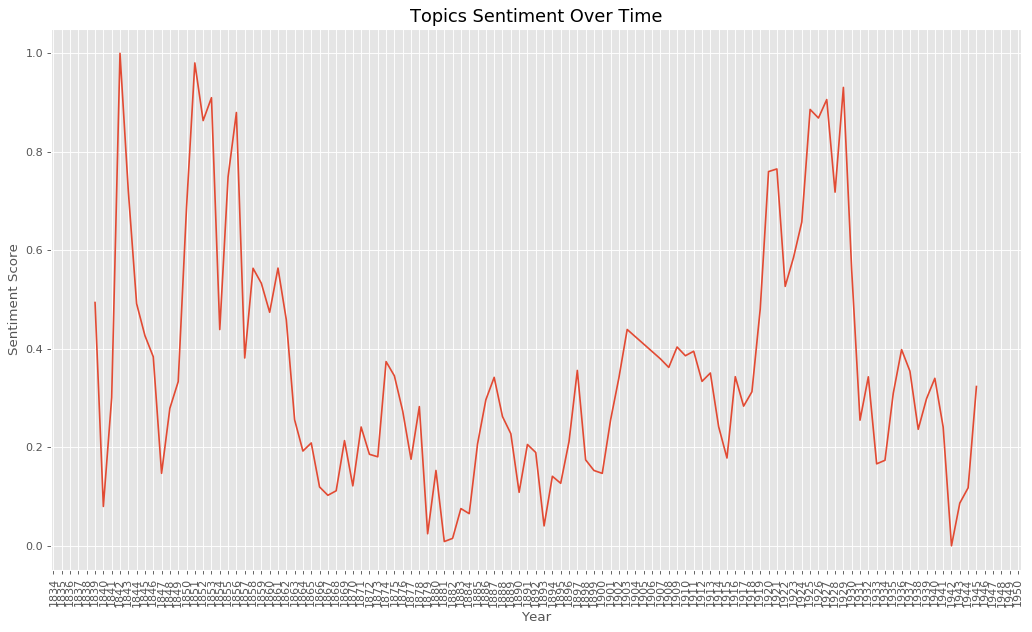

In [19]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)
year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot_date(df_plt.index, df_plt['scaled'], '-')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title("Topics Sentiment Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.savefig('../temp/sentiment.png')  
plt.show()  
plt.close()

**Although above process to generate sentiment based on topics are not very tight, it still display a reasonable answer for the question at the beginning. The first happy time begain in 1840 after The Treaty of Waitangi was assigned. The most happy period is after the WWI and drop quickly during the WWII.**

**The application of sentiment analysis on topic modeling is useful in historical research and social study.**

---

In [16]:
gc.collect()

15